## Experiment

In [1]:
import pandas as pd
import numpy as np
import glob
import pickle
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:

def get_feat_templates_classes (dataframe):
    feat_template_list = []
    class_list = []
    indices = [indel for indel,el in enumerate(dataframe.label) if not all([opt == "_" for opt in el.split("|")])]
    
    for annoix in indices:
        sentencename = dataframe.iloc[annoix][0]
        bol= [x.lower() for x in dataframe.loc[dataframe['Unnamed: 0'] == sentencename, 'lemma'].iloc[:]]
        surrounding_lemmas=[]#-4 to 4 surrounding lemmas + bag-of-lemmas
        sentencename = dataframe.iloc[annoix][0]
        bol= [x.lower() for x in dataframe.loc[dataframe['Unnamed: 0'] == sentencename, 'lemma'].iloc[:]]
        if annoix+n < len(dataframe):
            lemmas=[(dataframe.iloc[annoix+i][0], "lemma"+str(i)+"="+dataframe.iloc[annoix+i].lemma) for i in n_range]
        else:
            lemmas=[(dataframe.iloc[annoix+i][0], "lemma"+str(i)+"="+dataframe.iloc[annoix+i].lemma) for i in range(-n,(len(dataframe)-annoix)) if i!=0]
            for i in range ((len(dataframe)-annoix), n+1):
                lemmas.append((sentencename,"lemma"+str(i)+"=#"))
        index=-n
        for ix, lem in lemmas:
            if ix == sentencename:
                surrounding_lemmas.append(lem.lower())
            else:
                surrounding_lemmas.append('lemma'+str(index)+'=#')
            index = index + 1
            if index == 0:
                index = index + 1
        sentence_feat_templates = surrounding_lemmas + bol
        feat_template_list.append(sentence_feat_templates)
        class_list.append(dataframe.iloc[annoix].label)
    return (np.array(feat_template_list), np.array(class_list))

In [3]:
def hot_vector(size, sent_feat_temps):
    sent_feats = np.zeros(size)
    for element in sent_feat_temps:
        sent_feats[element] = 1    
    return sent_feats

hot_vector (10, [0,3])

array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [4]:
def create_vocab(fts):
    rV=[]
    for el in fts:
        rV.extend(el)
    rV=set(rV)
    return rV

#print (feattoint)
#print (inttofeat)

In [5]:
def evaluate (predicted, gold):
#    print ("PRedicted",len(predicted))
#    print ("gold",len(gold))
#    for indel, el in enumerate(gold):
#        print (predicted[indel], gold[indel], predicted[indel] in gold[indel].split("|"))
    correct = [predicted[indel] in gold[indel].split("|") for indel, el in enumerate(gold)]
#    print (np.sum(correct))
    return np.sum(correct)/len(gold)

In [6]:
path = "data_noOs_csv-files/*/output*.csv"

n=4 ##LEMMA WINDOW SIZE
n_range = [i for i in range(-n,n+1) if i!=0]
results={}
dummyresults={}
for file in glob.glob(path):
    print (file)
    results[file]=[]
    dummyresults[file]=[]
    df=pd.read_csv(file, sep='\t', usecols=[0,1,2,4,6])
    feat_templates, classes = get_feat_templates_classes(df)
    assert len(feat_templates) == len(classes)
#    classes = [not all([opt == "_" for opt in el.split("|")]) for el in dataframe.label]
#    indices = [indel for indel,el in enumerate(dataframe.label) if not all([opt == "_" for opt in el.split("|")])]

    kf = KFold(n_splits=5)
    for train, test in kf.split(feat_templates):
        V= create_vocab (feat_templates[train])
        V_inttofeat = dict(zip(range(len(V)), V))
        V_feattoint = dict(zip(V, range(len(V))))
        V_size = len(V)
        
        X_nr = np.array([hot_vector (V_size, [V_feattoint[active_feature] for active_feature in instance]) for instance in feat_templates[train]])

        X=[]
        Y=[]
        for ind_instance, each_instance in enumerate(classes[train]):
            possible_classes = each_instance.split("|")
            for each_class in possible_classes:
                X.append(X_nr[ind_instance])
                Y.append(each_class)
        clf = LinearSVC()
        clf.fit(X, Y)

        dummyclf = DummyClassifier()
        dummyclf.fit(X, Y)

        X_test_nr = np.array([hot_vector (V_size, [V_feattoint[active_feature] for active_feature in instance if active_feature in V_feattoint]) for instance in feat_templates[test]])
        
        y_pred = clf.predict(X_test_nr)
        dummyy_pred = dummyclf.predict(X_test_nr)
        
        evaluation = evaluate (y_pred, classes[test])
        dummyevaluation = evaluate (dummyy_pred, classes[test])

        results[file].append(evaluation)
        dummyresults[file].append(dummyevaluation)
        
    allwords=[]
    for w in feat_templates:
        allwords.extend(w)

data_noOs_csv-files/clustered/output0.csv
data_noOs_csv-files/clustered/output1.csv
data_noOs_csv-files/clustered/output2.csv
data_noOs_csv-files/clustered/output3.csv
data_noOs_csv-files/clustered/output4.csv
data_noOs_csv-files/clustered/output5.csv
data_noOs_csv-files/clustered/output6.csv
data_noOs_csv-files/clustered/output7.csv
data_noOs_csv-files/clustered/output8.csv
data_noOs_csv-files/clustered/output9.csv
data_noOs_csv-files/clustered-reduced/output0.csv
data_noOs_csv-files/clustered-reduced/output1.csv
data_noOs_csv-files/clustered-reduced/output2.csv
data_noOs_csv-files/clustered-reduced/output3.csv
data_noOs_csv-files/clustered-reduced/output4.csv
data_noOs_csv-files/clustered-reduced/output5.csv
data_noOs_csv-files/clustered-reduced/output6.csv
data_noOs_csv-files/clustered-reduced/output7.csv
data_noOs_csv-files/clustered-reduced/output8.csv
data_noOs_csv-files/clustered-reduced/output9.csv
data_noOs_csv-files/regular/output0.csv
data_noOs_csv-files/regular/output1.csv


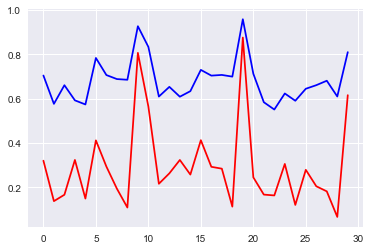

In [7]:
#print (dummy_results)
#print (svm_results)

#for file in results.keys():
#    print (file)
#    print (np.mean(results[file]))
#    print (np.mean(dummyresults[file]))
#    for fold in range(0,5):
#        print (results[file][fold], dummyresults[file][fold])
#    print ()
res = [np.mean(results[file]) for file in results.keys()]
dummyres = [np.mean(dummyresults[file]) for file in results.keys()]

plt.plot(range(len(res)), res, color='blue')
plt.plot(range(len(dummyres)), dummyres, color='red')


In [8]:
#X=[['aa','vv','aaa','aa','bbg'], ['zz','aa','bbg']]


#X_num = [[feattoint.get(feat_temp) for feat_temp in inst] for inst in X]
#X_num
clustered_reduced = pd.DataFrame(results).mean().iloc[0:10]
clustered = pd.DataFrame(results).mean().iloc[10:20]
regular = pd.DataFrame(results).mean().iloc[20:]
dummyclustered_reduced = pd.DataFrame(dummyresults).mean().iloc[0:10]
dummyclustered = pd.DataFrame(dummyresults).mean().iloc[10:20]
dummyregular = pd.DataFrame(dummyresults).mean().iloc[20:]


Current size: [6.0, 4.0]


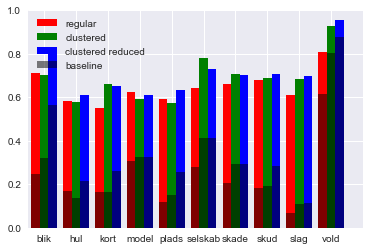

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

width =0.27
ind = np.arange(10)
plt.bar(ind-width, regular.values, width, color='red')
plt.bar(ind, clustered.values, width, color='green')
plt.bar(ind+width, clustered_reduced.values, width, color='blue')
plt.bar(ind-width, dummyregular.values, width, color='black', alpha=0.5)
plt.bar(ind, dummyclustered.values, width, color='black', alpha=0.5)
plt.bar(ind+width, dummyclustered_reduced.values, width, color='black', alpha=0.5)
clustered.values
ax.set_xticks(ind)
ax.set_xticklabels(('blik', 'hul', 'kort', 'model', 'plads', 'selskab', 'skade', 'skud', 'slag', 'vold'))
plt.legend(('regular', 'clustered', 'clustered reduced', 'baseline'));
plt.axis([-0.5, 10, 0.0, 1.0])
fig_size = plt.rcParams["figure.figsize"]
# Prints: Current size: [6.4, 4.8]
print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
#plt.savefig("accuracies_linearsvm.png", dpi=300)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.bar(ind-width, dummyregular.values, width, color='red')
plt.bar(ind, dummyclustered.values, width, color='green')
plt.bar(ind+width, dummyclustered_reduced.values, width, color='blue')
clustered.values
ax.set_xticks(ind)
ax.set_xticklabels(('blik', 'hul', 'kort', 'model', 'plads', 'selskab', 'skade', 'skud', 'slag', 'vold'))
plt.legend(('regular', 'clustered', 'clustered reduced'));
plt.axis([-0.5, 10, 0.0, 1.0])
fig_size = plt.rcParams["figure.figsize"]
# Prints: Current size: [6.4, 4.8]
print ("Current size:", fig_size)
# Set figure width to 12 and height to 9
fig_size[0] = 18
fig_size[1] = 11
plt.rcParams["figure.figsize"] = fig_size
plt.savefig("accuracies_dummy.png", dpi=300)